In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import StarmapParallelization
from multiprocessing.pool import ThreadPool

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
from okridge.solvel0 import *
from solvel0 import solvel0
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator
from bayesian_model_evidence import log_evidence

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
n_poly = 6
n_derivatives = 6
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
data = sio.loadmat(os.path.join(data_path, "burgers.mat"))
u_clean = (data['usol']).real; u = u_clean.copy()
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]; dx = x[2]-x[1]

### Add noise

In [4]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


### Denoise

In [5]:
load_denoised_data = True
if load_denoised_data:
    print("Loading denoised data...")
    u = np.load(f"./Denoised_data/burgers_{noise_type}{int(noise_lv)}_bm3d.npy")
else:
    kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
                    WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    
    xx = colvec(x)
    u_mean = np.copy(u)
    u_std = np.ones(u.shape)
    for i in trange(len(t)):    
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, 
                                       n_restarts_optimizer=10 # 20
                                      )
    
        gpr.fit(xx, u_mean[:, i])
        um, ustd = gpr.predict(xx, return_std=True)
        u_mean[:, i] = um
        u_std[:, i] = ustd
    
    est_sigma = u_std.mean() # max also works well
    # est_sigma = (est_sigma+estimate_sigma(u))/2
    u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

    np.save(f"./Denoised_data/burgers_{noise_type}{int(noise_lv)}_bm3d.npy", u)

Loading denoised data...


In [6]:
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [7]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    diff_kwargs={"is_uniform":True},
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))

In [8]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

### Straightforward best-subset selection

In [9]:
# over 30 minutes for n_poly = 6 and n_derivatives = 6
# miosr_subsets = solvel0(X_pre, y_pre, miosr=True)

In [10]:
# tau = 3
# verbose = True
# # scale = 1 <- generalized UBIC
# scale = np.log(len(y_pre))
# per = 75 # 80

# post_means, b_bics, b_uns = baye_uncertainties(miosr_subsets, (X_pre, y_pre), 
#                                                u_type='cv1', take_sqrt=True, 
#                                                ridge_lambda=0, 
#                                                threshold=0)
# # b_uns = ard_uns # USE ard_uns INSTEAD
# predictions = X_pre@post_means
# print(b_bics)
# print(b_uns)
# b_bics = np.array(b_bics)
# max_complexity = len(b_bics)
# complexities = np.arange(max_complexity)+1
# d_complexities = complexities[decreasing_values_indices(b_bics)]
# d_bics = b_bics[decreasing_values_indices(b_bics)]
# slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
# try:
#     thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
#     thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
# except IndexError:
#     thres = 1/40
# min_thres = 1/40
# thres = max(thres, min_thres)
# print("threshold:", thres)

# lower_bounds = []
# for k, efi in enumerate(miosr_subsets):
#     # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
#     com = len(efi)
#     lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
#     lower_bounds.append(lower_bound)

# last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
# print("max_lam:", last_lam)
# delta = last_lam/tau
# now_lam = last_lam-delta
# last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
# last_bc = np.argmin(last_ubic)
# bc_seq = [last_bc]
# while now_lam >= 0:
#     now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
#     now_bc = np.argmin(now_ubic)
    
#     diff_com = now_bc-last_bc
#     diff_bic = b_bics[now_bc]-b_bics[last_bc]
#     imp = np.nan
#     if diff_com != 0:
#         imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
#     if verbose:
#         print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
#               np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break
    
#     last_lam = now_lam
#     now_lam = round(last_lam-delta, 8)
#     last_ubic = now_ubic
#     last_bc = now_bc
#     if last_bc not in bc_seq:
#         bc_seq.append(last_bc)

# # best_bc = knee_finder(last_ubic)
# best_bc = knee(range(len(last_ubic)), last_ubic, 'linear')
# if best_bc == 0 and last_bc != 0 and abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
#     best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 'linear')

# if best_bc is None:
#     best_bc = last_bc
#     alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-10
#     cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) or \
#             abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc)))
#     if cond < thres: 
#         best_bc = np.argmin(last_ubic[:alt_bc+1])
    
# last_lam = round(last_lam, 8)
# print(last_lam, last_ubic, last_bc, best_bc)

# plt.plot(last_ubic)
# plt.show()

### Genetic algorithm with NSGA-II

In [11]:
class PdeDiscoveryProblem(ElementwiseProblem):
    def __init__(self, n_poly, n_derivatives, n_modules, 
                 base_features, u_t, order_complexity=False, **kwargs):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0, **kwargs)
        self.n_poly = n_poly
        self.n_derivatives = n_derivatives
        self.n_modules = n_modules
        self.base_features = base_features
        self.u_t = u_t
        self.sample_size = np.prod(self.u_t.shape)
        self.order_complexity = order_complexity

    def _evaluate(self, X, out, *args, **kwargs):
        genome = X[0]
        coeff, mse = self.compute_genome_coefficient(genome)
        mse = mse/self.sample_size
        complexity_penalty = len(genome)
        if self.order_complexity:
            complexity_penalty += sum(sum(_) for _ in genome)
        out["F"] = [mse, complexity_penalty]

    def numericalize_genome(self, genome):
        return np.stack([self.base_features[tuple(module)] 
                         for module in genome], axis=-1)

    def compute_genome_coefficient(self, genome):
        features = self.numericalize_genome(genome)
        features = features.reshape(-1, features.shape[-1])
        coeff, error, _, _ = np.linalg.lstsq(features, self.u_t, rcond=None)
        return coeff, error[0]
    
    def generate_module(self):
        return (random.randint(0, self.n_poly), random.randint(0, self.n_derivatives))
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def set_order_complexity(self, order_complexity):
        self.order_complexity = order_complexity
    
class PopulationSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)
        X_set = set()
        i = 0
        while i < n_samples:
            n_modules = random.randint(1, problem.n_modules)
            genome = frozenset(problem.generate_module() for _ in range(n_modules))
            if len(genome) > 0 and genome not in X_set:
                X_set.add(genome)
                X[i, 0] = genome
                i += 1
        return X
    
class DuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, g1, g2):
        return g1.X[0] == g2.X[0]

In [12]:
class GenomeCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        
        # for each mating provided
        for k in range(n_matings):
            # get the first and the second parent          
            Y[0, k, 0], Y[1, k, 0] = self.crossover_permutation(X[0, k, 0], X[1, k, 0])
            
        return Y
    
    def crossover_permutation(self, genome1, genome2):
        collection = list(genome1) + list(genome2)
        random.shuffle(collection)
        return frozenset(collection[:len(genome1)]), frozenset(collection[len(genome1):])
    
class GenomeMutation(Mutation):
    def __init__(self, add_rate=0.4, del_rate=0.5, order_rate=0.4):
        super().__init__()
        self.add_rate = add_rate
        self.del_rate = del_rate
        self.order_rate = order_rate

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            if random.random() < self.add_rate:
                X[i, 0] = self.add_mutate(problem, X[i, 0])
            if random.random() < self.del_rate:
                X[i, 0] = self.del_mutate(problem, X[i, 0])
            if random.random() < self.order_rate:
                X[i, 0] = self.module_mutate(problem, X[i, 0])
        return X
    
    def add_mutate(self, problem, genome, max_iter=3):
        for _ in range(max_iter):
            new_module = problem.generate_module()
            if new_module not in genome:
                return genome.union(frozenset({new_module}))
        return genome
    
    def del_mutate(self, problem, genome, max_iter=3):
        genome = list(genome)
        lg = len(genome)
        if lg > 0:
            if lg == 1:
                for _ in range(max_iter):
                    new_module = problem.generate_module()
                    if new_module != genome[0]:
                        return frozenset({new_module})
            else:
                genome.pop(random.randint(0, lg-1))
        return frozenset(genome)
    
    def module_mutate(self, problem, genome):
        if len(genome) == 0:
            return genome
        genome = set(genome)
        genome.remove(random.choice(list(genome)))
        for _ in range(3):
            new_module = problem.generate_module()
            if new_module not in genome:
                genome.add(new_module)
                return frozenset(genome)
        return frozenset(genome)

In [13]:
pop_size = 500
order_complexity = False
pool = ThreadPool(4)
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, order_complexity=order_complexity, 
                              elementwise_runner=StarmapParallelization(pool.starmap))

In [14]:
def add_prefix(file_path, prefix):
    dir_name, file_name = os.path.split(file_path)
    return os.path.join(dir_name, prefix + file_name)
load_pareto_front = False
pf_file_path = f"./Cache/pf_MOEAD_burgers_noise{int(noise_lv)}.npy"

if not load_pareto_front:
    ### DNSGA2 ###
    # termination = DefaultMultiObjectiveTermination(
    #     xtol=1e-10,
    #     cvtol=1e-8,
    #     ftol=1e-10,
    #     period=50,
    #     n_max_gen=100,
    #     n_max_evals=100000
    # )
    # algorithm = DNSGA2(pop_size=pop_size,
    #                 sampling=PopulationSampling(),
    #                 crossover=GenomeCrossover(),
    #                 mutation=GenomeMutation(),
    #                 eliminate_duplicates=DuplicateElimination(),
    #                 )

    ### MOEAD (Faster) ###
    from pymoo.algorithms.moo.moead import MOEAD
    from pymoo.util.ref_dirs import get_reference_directions
    termination = DefaultMultiObjectiveTermination(
        xtol=1e-10,
        cvtol=1e-8,
        ftol=1e-10,
        period=100,
        n_max_gen=5000,
        n_max_evals=100000
    )
    algorithm = MOEAD(
        ref_dirs=get_reference_directions("uniform", 2, n_partitions=5),
        n_neighbors=4,
        prob_neighbor_mating=0.9,
        sampling=PopulationSampling(),
        crossover=GenomeCrossover(),
        mutation=GenomeMutation()
    )

    res = minimize(problem,
                algorithm,
                termination=termination,
                verbose=True)
    
    pareto_optimal_models = res.X
    np.save(pf_file_path, pareto_optimal_models)

else:
    pareto_optimal_models = np.load(pf_file_path, allow_pickle=True)

np.random.seed(0)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        6 |      2 |             - |             -
     2 |       12 |      5 |  0.1666666667 |         ideal
     3 |       18 |      4 |  6.0000000000 |         nadir
     4 |       24 |      5 |  0.000000E+00 |             f
     5 |       30 |      5 |  0.000000E+00 |             f
     6 |       36 |      5 |  0.000000E+00 |             f
     7 |       42 |      5 |  1.0000000000 |         ideal
     8 |       48 |      5 |  0.5482625865 |         ideal
     9 |       54 |      5 |  0.000000E+00 |             f
    10 |       60 |      5 |  0.000000E+00 |             f
    11 |       66 |      5 |  0.000000E+00 |             f
    12 |       72 |      5 |  0.000000E+00 |             f
    13 |       78 |      5 |  0.000000E+00 |             f
    14 |       84 |      5 |  0.000000E+00 |             f
    15 |       90 |      5 |  0.000000E+00 |             f
    16 |       96 |      5 |  0.000000E+00 |            

In [15]:
### OPTIONAL: REFINE PARETO FRONT ###
from operator import itemgetter

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
effective_candidates = sorted(effective_candidates)

new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), y_pre)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
np.save(add_prefix(pf_file_path, 'refined_'), pareto_optimal_models)
pareto_optimal_models

array([[frozenset({(0, 1)})],
       [frozenset({(1, 1), (0, 2)})],
       [frozenset({(1, 1), (0, 2), (0, 4)})],
       [frozenset({(1, 1), (0, 2), (0, 4), (6, 4)})],
       [frozenset({(0, 4), (1, 1), (6, 4), (4, 2), (0, 2)})],
       [frozenset({(0, 4), (1, 1), (5, 1), (4, 2), (6, 4), (0, 2)})],
       [frozenset({(0, 4), (1, 1), (5, 1), (4, 2), (6, 4), (0, 2), (6, 0)})],
       [frozenset({(0, 4), (1, 1), (4, 6), (5, 1), (4, 2), (6, 4), (0, 2), (6, 0)})],
       [frozenset({(0, 4), (1, 1), (4, 6), (5, 1), (4, 2), (6, 4), (0, 2), (6, 0), (6, 6)})],
       [frozenset({(0, 4), (1, 1), (0, 3), (4, 6), (5, 1), (4, 2), (6, 4), (0, 2), (6, 0), (6, 6)})],
       [frozenset({(0, 4), (1, 1), (0, 3), (4, 6), (5, 1), (4, 2), (5, 4), (6, 4), (0, 2), (6, 0), (6, 6)})],
       [frozenset({(6, 0), (0, 4), (1, 1), (0, 3), (4, 6), (5, 1), (4, 2), (5, 4), (6, 4), (0, 2), (2, 2), (6, 6)})],
       [frozenset({(4, 0), (0, 4), (6, 0), (1, 1), (0, 3), (4, 6), (5, 1), (4, 2), (5, 4), (6, 4), (0, 2), (2, 2

0.00024255734203272388 0.00024563158549299063
pf_base >= pf


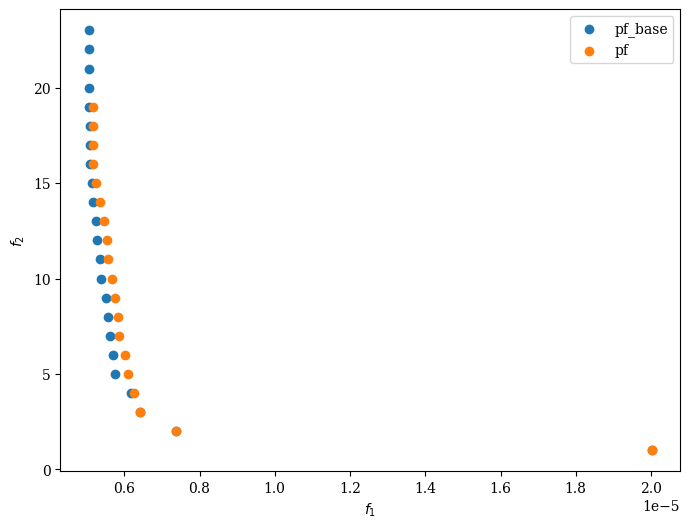

In [16]:
from pymoo.indicators.hv import HV
from pymoo.visualization.scatter import Scatter

problem.set_order_complexity(False)
pf = problem.evaluate(pareto_optimal_models)
pf_base = problem.evaluate(np.load("./Cache/refined_pf_burgers_noise50.npy", allow_pickle=True))
problem.set_order_complexity(order_complexity)

ref_point = np.array([pf.max(axis=0), pf_base.max(axis=0)]).min(axis=0)
vol = HV(ref_point=ref_point)(pf)
vol_base = HV(ref_point=ref_point)(pf_base)
print(vol, vol_base)
print("pf > pf_base") if vol > vol_base else print("pf_base >= pf")

Scatter(legend=True)\
.add(pf_base, label='pf_base')\
.add(pf, label='pf')\
.show()

### Compromise programming ###

In [17]:
# from pymoo.decomposition.asf import ASF
# import mcdm

# est_complexities = {}
# F = problem.evaluate(pareto_optimal_models)
# nF = (F - F.min(axis=0))/(F.max(axis=0) - F.min(axis=0))
# for weights in np.arange(0.1, 1, 0.1):
#     decomp = ASF()
#     # est_complexity = int(F[decomp.do(nF, 1/np.array([1-weights, weights])).argmin()][1])
#     # est_complexity = mcdm.rank(nF, alt_names=list(map(int, F[:, 1].astype(np.int32))), is_benefit_x=[False, False], 
#     #                            n_method=None, w_vector=[1-weights, weights], s_method="mTOPSIS")[0][0]    
#     est_complexity = mcdm.rank(F, alt_names=list(map(int, F[:, 1].astype(np.int32))), is_benefit_x=[False, False], 
#                                n_method="linear2", w_vector=[1-weights, weights], s_method="mTOPSIS")[0][0]
#     if est_complexity not in est_complexities:
#         est_complexities[est_complexity] = 1
#     else:
#         est_complexities[est_complexity] += 1
        
# est_complexities = sorted(est_complexities.items(), key=lambda _: (_[1], -_[0]), reverse=True)
# est_complexities = [_[0] for _ in est_complexities]
# min_ss = min(est_complexities)
# max_ss = max(est_complexities)
# if max_ss == min_ss:
#     max_ss += 1

# # epsilon = 10**sci_format(np.median(res.F[:, 0:1]))[1]
# # pareto_optimal_models = res.X[np.argsort(res.F[:, 0]+epsilon*res.F[:, 1])]
# keep_indices = [i for i in range(len(pareto_optimal_models)) if min_ss <= len(pareto_optimal_models[i][0]) <= max_ss]
# pareto_optimal_models = pareto_optimal_models[keep_indices]

# est_complexities, pareto_optimal_models

In [18]:
from pymcdm.methods import TOPSIS, MABAC, COMET, SPOTIS
from pymcdm import weights as obj_w
from pymcdm.helpers import rrankdata
from pymcdm.methods.comet_tools import MethodExpert
from pymcdm import visuals

F = problem.evaluate(pareto_optimal_models)
nF = (F - F.min(axis=0))/(F.max(axis=0) - F.min(axis=0))

obj_weights = obj_w.entropy_weights(F)
types = [-1, -1]
cvalues = COMET.make_cvalues(F)
expert_function = MethodExpert(TOPSIS(), obj_weights, types)
bounds = SPOTIS.make_bounds(F)

method_names = ['TOPSIS', 'MABAC', 'COMET', 'SPOTIS']
methods = [
    TOPSIS(),
    MABAC(),
    COMET(cvalues, expert_function),
    SPOTIS(bounds)
]

ranks = [method.rank(method(F, obj_weights, types)) for method in methods]
est_complexities = sorted(set(np.argsort(ranks)[:, 0]))
pareto_optimal_models = pareto_optimal_models[est_complexities]
est_complexities = F[est_complexities][:, 1].astype(np.int32)
min_ss = min(est_complexities)
max_ss = max(est_complexities)
if max_ss == min_ss:
    max_ss += 1

# fig, ax = plt.subplots(figsize=(7, 3), dpi=300, tight_layout=True)
# visuals.ranking_bar(ranks, labels=method_names, ax=ax)
# plt.show()

pareto_optimal_models

array([[frozenset({(1, 1), (0, 2)})]], dtype=object)

In [19]:
significance_threshold = None # 0.95

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
effective_candidates = sorted(effective_candidates)

effective_candidates = {_: 0.0 for _ in effective_candidates}
for i in range(len(pareto_optimal_models)):
    potential_pde = list(pareto_optimal_models[i][0])
    important_scores = shap_linear_importance(problem.numericalize_genome(potential_pde), 
                                              y_pre, scale=True)
    for j in range(len(potential_pde)):
        effective_candidates[potential_pde[j]] += important_scores[j]
        
total_score = sum(effective_candidates.values())
for _ in effective_candidates:
    effective_candidates[_] = effective_candidates[_]/total_score
    
effective_candidates = sorted(effective_candidates.items(), key=lambda _: _[1], reverse=True)
X_pre_effective = problem.numericalize_genome([_[0] for _ in effective_candidates])

cum_sum = 0
cum_sums = []
top_candidates = []
for i in range(len(effective_candidates)):
    cum_sum += effective_candidates[i][1]
    cum_sums.append(cum_sum)
    top_candidates.append(effective_candidates[i][0])
if significance_threshold is not None:
    top_candidates = top_candidates[:np.argmax((np.array(cum_sums) > significance_threshold).astype(np.int8))+1]
else:
    top_candidates = top_candidates[:knee(range(0, len(cum_sums)), cum_sums, S=1, direction='increasing')+1]

if len(top_candidates) > max_ss:
    top_candidates = np.array(top_candidates)[np.nonzero(linear_model.ARDRegression(max_iter=500, fit_intercept=False).fit(problem.numericalize_genome(top_candidates), y_pre.ravel()).coef_)[0]]
else:
    top_candidates = np.array(top_candidates)
X_pre_top = problem.numericalize_genome(top_candidates)

top_candidates

array([[1, 1],
       [0, 2]])

### Best-subset selection

In [20]:
best_subsets = solvel0(X_pre_top, y_pre, miosr=True, refine=True)

# _, best_subsets = okridge_solvel0_full(X_pre_top, y_pre, 
#                                        k=X_pre_top.shape[-1], norm='l2')
# best_subsets = backward_refinement(best_subsets, (X_pre_top, y_pre), 
#                                    ic_type='bic', verbose=False).get_best_subsets()

best_subsets = [tuple(best_subsets[-1][_] for _ in bs) 
                for bs in brute_force_all_subsets(X_pre_top[:, best_subsets[-1]], y_pre)[1]]

  0%|          | 0/2 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-04


100%|██████████| 2/2 [00:00<00:00, 721.23it/s]


### Model selection using UBIC

In [21]:
# TODO: Calculate post_means for ARDRegression as well (Implement the ard_uncertainties function)
ard_uns = []
threshold_lambda = 5e5 # must pass assert 
for bs in best_subsets:
    ard = linear_model.ARDRegression(fit_intercept=False, 
                                     compute_score=True,
                                     threshold_lambda=threshold_lambda)
    ard.fit(X_pre_top[:, bs], y_pre.ravel())
    print(len(bs), end=', ')
    assert len(bs) == len(np.nonzero(ard.coef_)[0])
    pde_uncert = np.sqrt(np.diag(ard.sigma_)).sum()
    ard_uns.append(pde_uncert)
ard_uns = np.array(ard_uns)
ard_uns = ard_uns/min(ard_uns)
ard_uns

1, 2, 

array([1.33323565, 1.        ])

In [22]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

# best_bc = knee_finder(last_ubic)
best_bc = knee(range(len(last_ubic)), last_ubic, 0.95, 'linear', direction='decreasing')
if best_bc == 0 and last_bc != 0 and b_bics[last_bc] < b_bics[0] and \
                                    abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 0.95, 'linear')
if best_bc is None:
    best_bc = knee_finder(last_ubic)
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-79555.66805059963, -89773.43439679421]
[1.60628311 1.        ]
threshold: 0.2
max_lam: 3.988872159961028
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(-0.0, array([-79540.87363639, -89764.22405642]), 1, 1)

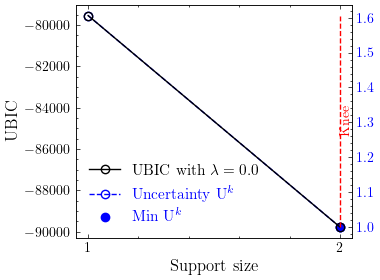

In [23]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), linestyles='--', color='red')
    ax.text(best_bc+1, np.mean(last_ubic), 'Knee', color='red', rotation=90, verticalalignment='center')
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='lower left', fontsize=11)
    plt.tight_layout()
    # plt.savefig(f"Figures/ubic_burgers_noise{int(noise_lv)}.pdf")
    plt.savefig(f"Figures/ubic_MOEAD_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

### Visualization ###

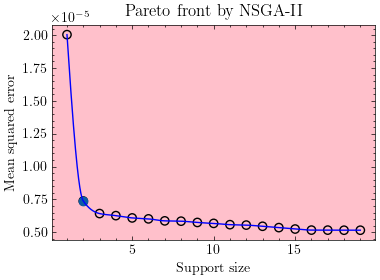

In [24]:
from scipy.interpolate import CubicSpline, PchipInterpolator
pareto_front = np.load(add_prefix(pf_file_path, 'refined_'), allow_pickle=True)
pareto_front = problem.evaluate(pareto_front)
pareto_front = pareto_front[np.argsort(pareto_front[:, 1])]
spline = PchipInterpolator(pareto_front[:, 1], pareto_front[:, 0])
x_plot = np.linspace(pareto_front[:, 1].min(), pareto_front[:, 1].max(), len(pareto_front[:, 1])*100)

bg_color = 'pink'
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = bg_color
    plt.figure(figsize=(4, 3))
    plt.plot(x_plot, spline(x_plot), color='blue')
    plt.scatter(pareto_front[:, 1], pareto_front[:, 0], facecolor='None', edgecolors='black')
    plt.scatter([_ for _ in est_complexities], pareto_front[:, 0][[_-1 for _ in est_complexities]])
    plt.ylabel("Mean squared error")
    plt.xlabel("Support size")
    plt.title("Pareto front by NSGA-II")
    plt.tight_layout()
    # plt.savefig(f"Figures/pf_burgers_noise{int(noise_lv)}.pdf")
    plt.savefig(f"Figures/pf_MOEAD_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

In [25]:
pool.close()

In [26]:
raise Exception

Exception: 

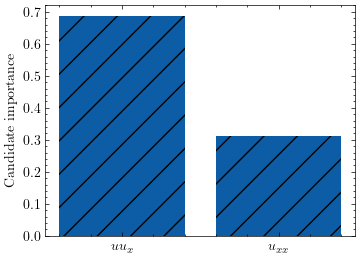

In [27]:
import sympy
def show_polynomial_derivative(p: int, d: int):
    if p < 0 or d < 0:
        raise ValueError("Polynomial degree and derivative order must be non-negative integers.")
    polynomial_part = sympy.Symbol('u') if p == 1 else sympy.Symbol(f"u^{p}") if p > 0 else sympy.Integer(1)    
    derivative_part = f"u_{'x'*d}" if d > 0 else ''
    if len(derivative_part) < 1:
        return sympy.simplify(polynomial_part)
    derivative_part = sympy.Symbol(derivative_part)
    return sympy.simplify(polynomial_part*derivative_part)
effective_candidates_name = ['$'+sympy.latex(show_polynomial_derivative(_[0][0], _[0][1]))+'$' for _ in effective_candidates]
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(4, 3))
    bars = ax.bar(effective_candidates_name, [_[1] for _ in effective_candidates])
    for i, bar in enumerate(bars):
        if i < len(top_candidates):
            bar.set_hatch('/')
    ax.set_ylabel("Candidate importance")
    # plt.savefig(f"Figures/importance_burgers_noise{int(noise_lv)}.pdf")
    plt.savefig(f"Figures/importance_MOEAD_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

### Bayesian model evidence ###

In [28]:
v = 1e-2
while 1:
    bme = [log_evidence(X_pre_top, y_pre, effective_indices=bs, v=v) for bs in best_subsets]
    if np.argmax(bme) >= knee_finder(b_bics): break
    else: v *= 10
bme_knee = knee(range(len(bme)), bme, 0.95, 'linear', direction='increasing')
bme, np.argmax(bme), bme_knee

([5859.278918090536, 5860.979509666952], 1, 1)

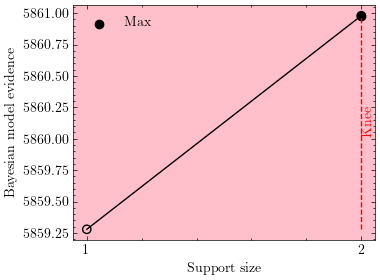

In [29]:
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = 'pink'
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, len(bme)+1), bme, color='black')
    plt.scatter(range(1, len(bme)+1), bme, facecolor='None', edgecolors='black')
    plt.scatter(np.argmax(bme)+1, bme[np.argmax(bme)], label='Max', color='black')
    plt.vlines(bme_knee+1, min(bme), max(bme), linestyles='--', color='red')
    plt.xlabel("Support size")
    plt.ylabel("Bayesian model evidence")
    plt.xticks(range(1, len(bme)+1))
    plt.text(bme_knee+1, np.mean(bme), 'Knee', color='red', rotation=90, verticalalignment='center')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"Figures/bme_burgers_noise{int(noise_lv)}.pdf")
    plt.savefig(f"Figures/bme_MOEAD_burgers_noise{int(noise_lv)}.pdf")
    plt.show()